In [40]:
# Libraries to import data
import pandas as pd
import numpy as np

# Libraries to Handle Warnings
import warnings
warnings.filterwarnings('ignore')

TPU Distribution strategy

In [41]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


Loading Dataset

In [42]:
# Load the train dataset into pandas dataframe
train = pd.read_csv('/content/datasets/train.csv')
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,These comments were considered in formulating ...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [43]:
# size of dataset
train.shape

(12120, 6)

In [44]:
# Column names of dataset
train.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')

In [45]:
# Data type of columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [46]:
train.nunique()

,0
id,12120
premise,8210
hypothesis,12119
lang_abv,15
language,15
label,3


In [47]:
train.isnull().sum()

,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0


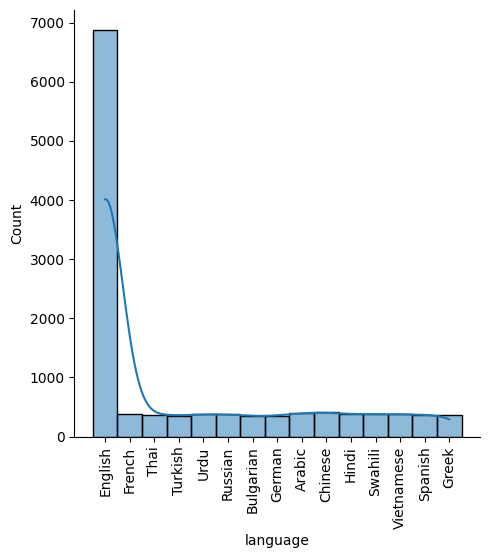

In [49]:
import seaborn as sns
sns.displot(train['language'], kde = True)
plt.xticks(rotation=90)  # Change rotation angle as needed
plt.yticks(rotation=0)  # For y-axis labels, if needed

plt.show()

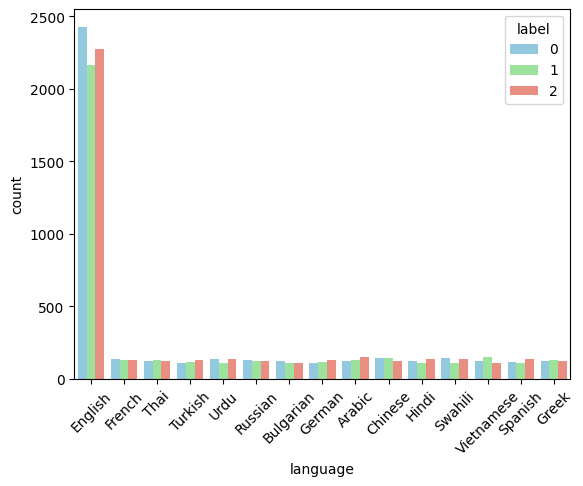

In [50]:
# Plot 2: Bar chart of label distribution per language
sns.countplot(data=train, x='language',  hue='label',palette=['skyblue', 'lightgreen', 'salmon'])
plt.xticks(rotation=45)
plt.show()

Checking Dataset Label balancing

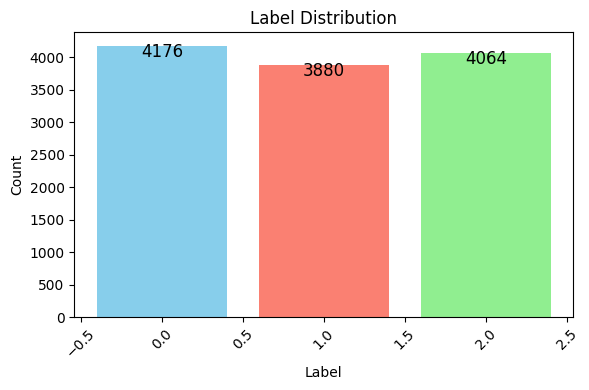

In [51]:


# Count each label (adjust 'label' to match your actual column name if necessary)
label_counts = train['label'].value_counts()

# Plotting the label distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Adding count values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()

Data Preprocessing

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load dataset
DATASET_PATH = './datasets/train.csv'  # Path to train.csv
data = pd.read_csv(DATASET_PATH)

# Drop rows with missing values in critical columns
data_cleaned = data.dropna(subset=["premise", "hypothesis", "label"])

# Split into training (80%) and testing (20%)
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Print dataset overview
print(f"Training Dataset: {len(train_data)} samples")
print(f"Testing Dataset: {len(test_data)} samples")


Training Dataset: 9696 samples
Testing Dataset: 2424 samples


Pre Training

In [25]:
from transformers import AutoTokenizer

# Define a preprocessing function for tokenization
def preprocess_function(examples, tokenizer):
    tokenized = tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["label"]  # Add labels to tokenized output
    return tokenized

# Select tokenizer (example: BERT)
model_name = "bert-base-multilingual-cased"  # Update for each model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure labels are integers
train_dataset = train_dataset.map(lambda x: {"label": int(x["label"])})
test_dataset = test_dataset.map(lambda x: {"label": int(x["label"])})

# Tokenize the datasets
tokenized_train = train_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_test = test_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)

# Print tokenized dataset details
print("Tokenization complete!")
print(f"Tokenized Training Dataset: {len(tokenized_train)} samples")
print(f"Tokenized Testing Dataset: {len(tokenized_test)} samples")


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenization complete!
Tokenized Training Dataset: 9696 samples
Tokenized Testing Dataset: 2424 samples


In [26]:
from transformers import AutoModelForSequenceClassification, TrainingArguments

# Define the model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save model outputs
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    learning_rate=2e-5,                 # Learning rate for fine-tuning
    per_device_train_batch_size=16,     # Batch size for training
    per_device_eval_batch_size=16,      # Batch size for evaluation
    num_train_epochs=3,                 # Number of training epochs
    weight_decay=0.01,                  # Weight decay for regularization
    logging_dir="./logs",               # Directory for logs
    save_strategy="epoch",              # Save model checkpoints every epoch
    save_total_limit=1                  # Keep only the last checkpoint
)

print("Model and training arguments are ready!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and training arguments are ready!


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# sets up a Trainer object from the Hugging Face Transformers library
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

print("Training complete!")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.944800,0.825687,0.634901,0.637022,0.634901,0.634745
2,0.723100,0.809062,0.652228,0.654332,0.652228,0.652194
3,0.574900,0.902256,0.653878,0.657148,0.653878,0.654619


Training complete!


In [28]:
# Define the model variants to evaluate
model_variants = [
    "bert-base-multilingual-cased",
    "roberta-base",
    "distilbert-base-multilingual-cased",
    "xlm-roberta-base"
]

# Dictionary to store results for comparison
results = {}


Model Evaluation


Training and Evaluating: bert-base-multilingual-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.923100,0.811042,0.639439,0.642431,0.639439,0.640356
2,0.680600,0.842763,0.651403,0.654419,0.651403,0.651346
3,0.536400,0.958524,0.643977,0.649543,0.643977,0.644833


Evaluation Results for bert-base-multilingual-cased:
eval_loss: 0.9585
eval_accuracy: 0.6440
eval_precision: 0.6495
eval_recall: 0.6440
eval_f1: 0.6448
eval_runtime: 4.7430
eval_samples_per_second: 511.0740
eval_steps_per_second: 32.0480
epoch: 3.0000

Classification Report:
               precision    recall  f1-score   support

   Entailment       0.72      0.63      0.67       851
      Neutral       0.62      0.63      0.63       773
Contradiction       0.60      0.67      0.64       800

     accuracy                           0.64      2424
    macro avg       0.65      0.64      0.64      2424
 weighted avg       0.65      0.64      0.64      2424



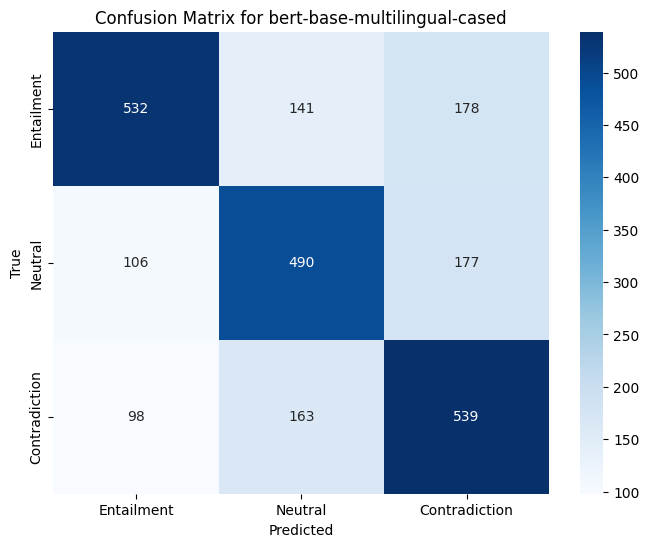


Training and Evaluating: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.007700,0.826041,0.594472,0.598574,0.594472,0.595615
2,0.748200,0.799809,0.637376,0.639953,0.637376,0.638254
3,0.647600,0.843469,0.651403,0.653615,0.651403,0.651851


Evaluation Results for roberta-base:
eval_loss: 0.8435
eval_accuracy: 0.6514
eval_precision: 0.6536
eval_recall: 0.6514
eval_f1: 0.6519
eval_runtime: 4.5959
eval_samples_per_second: 527.4290
eval_steps_per_second: 33.0730
epoch: 3.0000

Classification Report:
               precision    recall  f1-score   support

   Entailment       0.71      0.66      0.68       851
      Neutral       0.62      0.62      0.62       773
Contradiction       0.63      0.68      0.65       800

     accuracy                           0.65      2424
    macro avg       0.65      0.65      0.65      2424
 weighted avg       0.65      0.65      0.65      2424



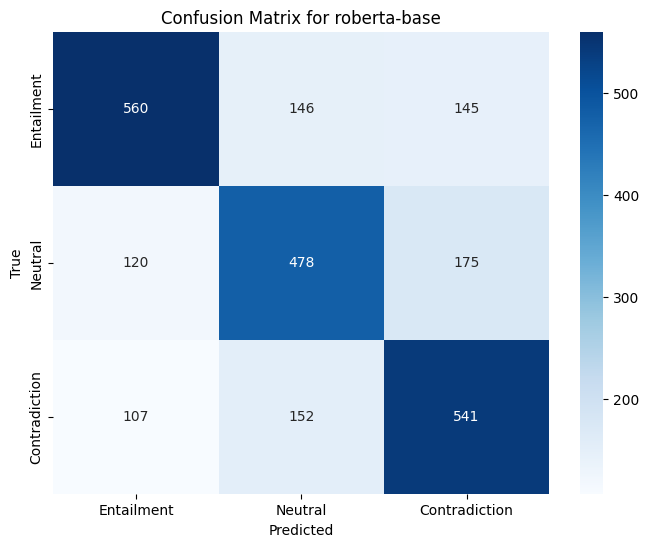


Training and Evaluating: distilbert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.000000,0.902155,0.579208,0.583179,0.579208,0.579876
2,0.813700,0.895511,0.600248,0.612257,0.600248,0.598922
3,0.702500,0.952730,0.599422,0.601869,0.599422,0.600026


Evaluation Results for distilbert-base-multilingual-cased:
eval_loss: 0.9527
eval_accuracy: 0.5994
eval_precision: 0.6019
eval_recall: 0.5994
eval_f1: 0.6000
eval_runtime: 2.6651
eval_samples_per_second: 909.5230
eval_steps_per_second: 57.0330
epoch: 3.0000

Classification Report:
               precision    recall  f1-score   support

   Entailment       0.65      0.61      0.63       851
      Neutral       0.56      0.61      0.58       773
Contradiction       0.59      0.58      0.59       800

     accuracy                           0.60      2424
    macro avg       0.60      0.60      0.60      2424
 weighted avg       0.60      0.60      0.60      2424



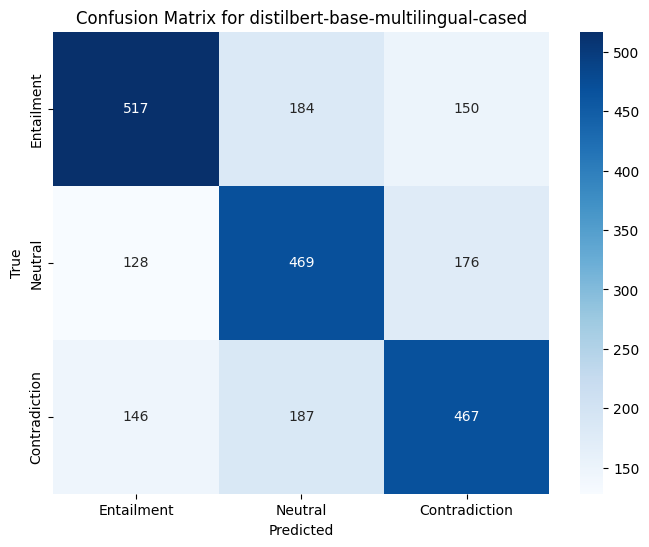


Training and Evaluating: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.073300,0.938623,0.581271,0.576572,0.581271,0.576627
2,0.877400,0.800061,0.655528,0.665985,0.655528,0.650021
3,0.733900,0.764223,0.688531,0.690637,0.688531,0.689228


Evaluation Results for xlm-roberta-base:
eval_loss: 0.7642
eval_accuracy: 0.6885
eval_precision: 0.6906
eval_recall: 0.6885
eval_f1: 0.6892
eval_runtime: 4.5973
eval_samples_per_second: 527.2640
eval_steps_per_second: 33.0630
epoch: 3.0000

Classification Report:
               precision    recall  f1-score   support

   Entailment       0.72      0.71      0.72       851
      Neutral       0.62      0.66      0.64       773
Contradiction       0.72      0.69      0.70       800

     accuracy                           0.69      2424
    macro avg       0.69      0.69      0.69      2424
 weighted avg       0.69      0.69      0.69      2424



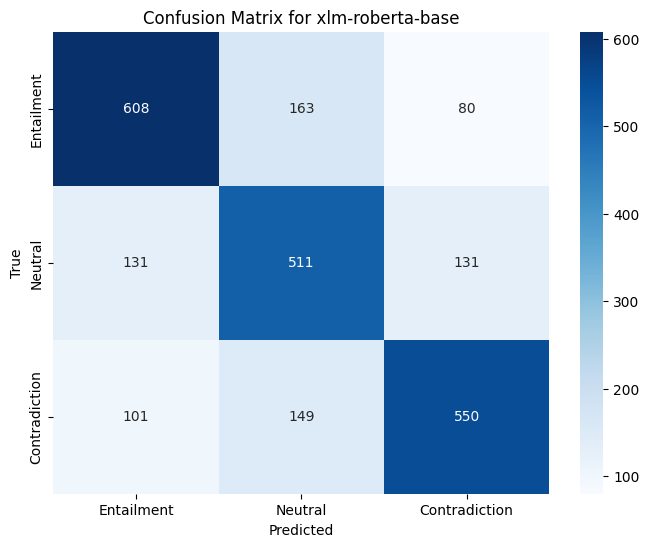

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Loop through each model variant
for model_name in model_variants:
    print(f"\nTraining and Evaluating: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # Tokenize the datasets
    tokenized_train = train_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    tokenized_test = test_dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{model_name.replace('/', '_')}",  # Unique output directory
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir=f"./logs_{model_name.replace('/', '_')}",
        save_strategy="epoch",
        save_total_limit=1
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    evaluation_results = trainer.evaluate()
    print(f"Evaluation Results for {model_name}:")
    for key, value in evaluation_results.items():
        print(f"{key}: {value:.4f}")

    # Store the evaluation results for comparison
    results[model_name] = evaluation_results

    # Generate predictions
    predictions = trainer.predict(tokenized_test)
    y_true = predictions.label_ids
    y_pred = predictions.predictions.argmax(axis=-1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Entailment", "Neutral", "Contradiction"]))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Entailment", "Neutral", "Contradiction"], yticklabels=["Entailment", "Neutral", "Contradiction"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



Model Performance Comparison:
                                Model  Accuracy  Precision    Recall  F1-Score
0        bert-base-multilingual-cased  0.643977   0.649543  0.643977  0.644833
1                        roberta-base  0.651403   0.653615  0.651403  0.651851
2  distilbert-base-multilingual-cased  0.599422   0.601869  0.599422  0.600026
3                    xlm-roberta-base  0.688531   0.690637  0.688531  0.689228


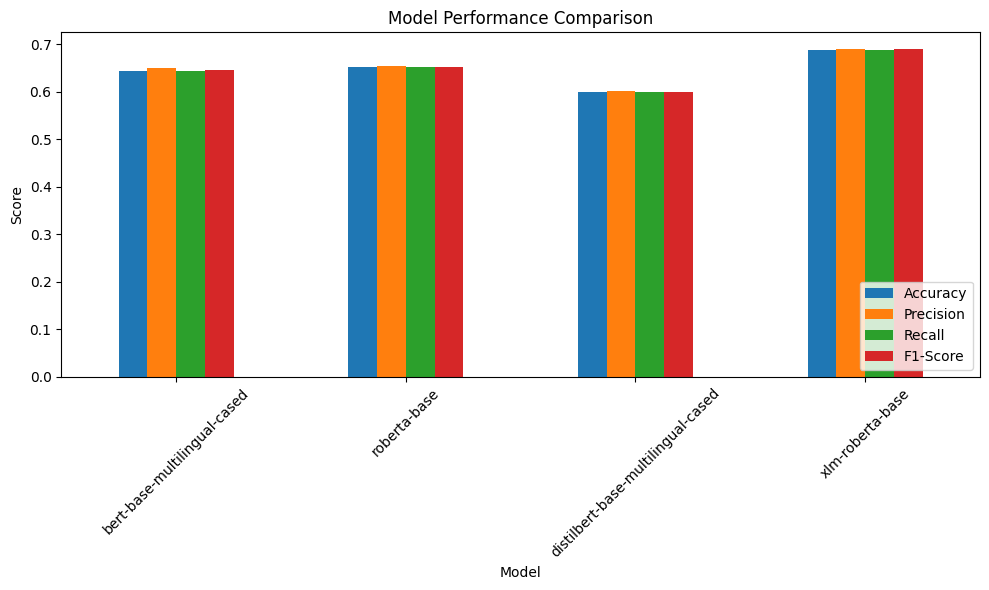

In [30]:
# Create a DataFrame to summarize results
comparison_df = pd.DataFrame([
    {
        "Model": model_name,
        "Accuracy": results[model_name]["eval_accuracy"],
        "Precision": results[model_name]["eval_precision"],
        "Recall": results[model_name]["eval_recall"],
        "F1-Score": results[model_name]["eval_f1"],
    }
    for model_name in model_variants
])

# Print comparison table
print("\nModel Performance Comparison:")
print(comparison_df)

# Plot comparison
comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



Best Performing Models by Metric:
Best Accuracy: xlm-roberta-base - 0.6885
Best Precision: xlm-roberta-base - 0.6906
Best Recall: xlm-roberta-base - 0.6885
Best F1-Score: xlm-roberta-base - 0.6892

Performance Differences:
                                    Accuracy  Precision    Recall  F1-Score
Model                                                                      
roberta-base                        0.007426   0.004072  0.007426  0.007018
distilbert-base-multilingual-cased -0.051980  -0.051746 -0.051980 -0.051825
xlm-roberta-base                    0.089109   0.088768  0.089109  0.089202

Confusion Matrix for bert-base-multilingual-cased:


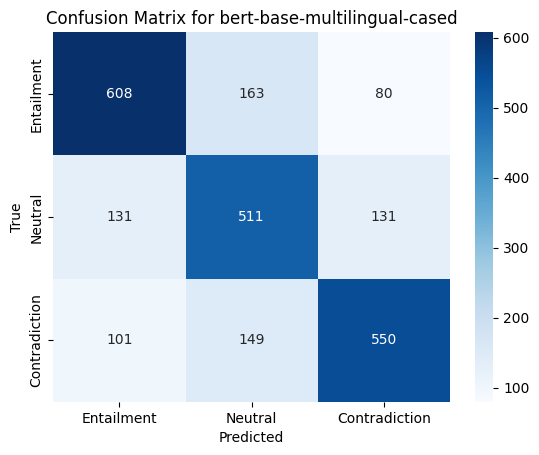


Confusion Matrix for roberta-base:


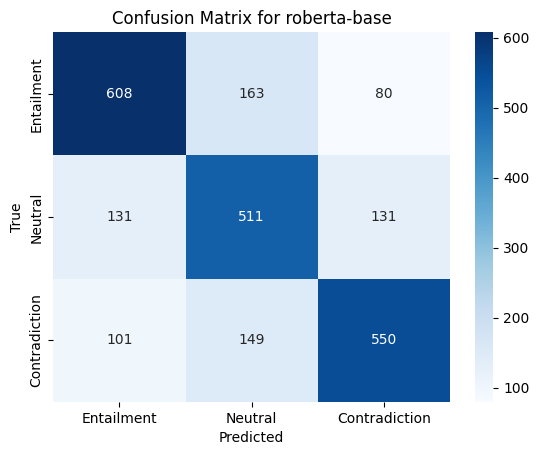


Confusion Matrix for distilbert-base-multilingual-cased:


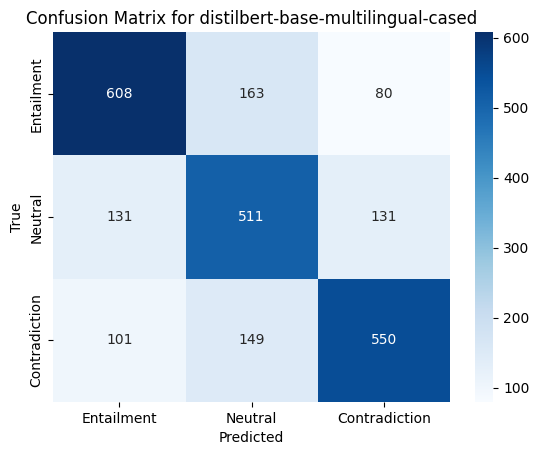


Confusion Matrix for xlm-roberta-base:


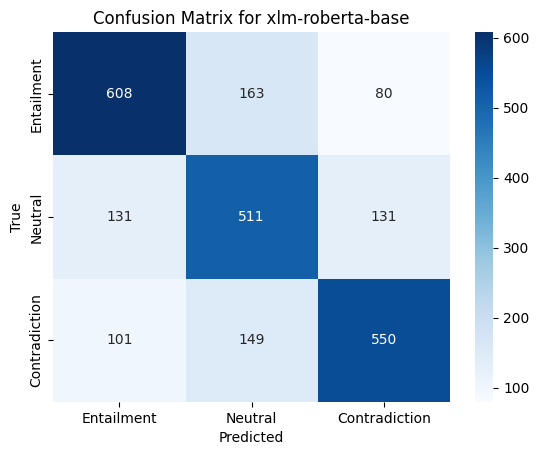

In [31]:
# Print the best-performing model for each metric
print("\nBest Performing Models by Metric:")
print(f"Best Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} - {comparison_df['Accuracy'].max():.4f}")
print(f"Best Precision: {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Model']} - {comparison_df['Precision'].max():.4f}")
print(f"Best Recall: {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']} - {comparison_df['Recall'].max():.4f}")
print(f"Best F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']} - {comparison_df['F1-Score'].max():.4f}")

# Analyze differences in performance
print("\nPerformance Differences:")
print(comparison_df.set_index("Model").diff().iloc[1:])

# Highlight confusion matrices for each model
for model_name in model_variants:
    print(f"\nConfusion Matrix for {model_name}:")
    predictions = trainer.predict(tokenized_test)  # Ensure predictions are obtained for the correct model
    y_true = predictions.label_ids
    y_pred = predictions.predictions.argmax(axis=-1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Entailment", "Neutral", "Contradiction"], yticklabels=["Entailment", "Neutral", "Contradiction"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [32]:
# Identify the best-performing model (based on F1-Score)
best_model_name = comparison_df.loc[comparison_df["F1-Score"].idxmax(), "Model"]
print(f"\nBest Model: {best_model_name}")

# Reload the best model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_name)
model = AutoModelForSequenceClassification.from_pretrained(best_model_name, num_labels=3)

# Save the best model and tokenizer
save_path = f"./best_model_{best_model_name.replace('/', '_')}"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Best model and tokenizer saved to: {save_path}")




Best Model: xlm-roberta-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model and tokenizer saved to: ./best_model_xlm-roberta-base


In [33]:
import torch

# Load the best model and tokenizer for inference
model = AutoModelForSequenceClassification.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

# Define a prediction function
def predict(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_class = torch.argmax(probs, dim=-1).item()
    labels = ["Entailment", "Neutral", "Contradiction"]
    return {"prediction": labels[pred_class], "probabilities": probs.tolist()}

# Example real-time data
premise = "The sky is blue."
hypothesis = "It is raining."
result = predict(premise, hypothesis)

print(f"\nPrediction: {result['prediction']}")
print(f"Probabilities: {result['probabilities']}")



Prediction: Neutral
Probabilities: [[0.28772062063217163, 0.46712133288383484, 0.24515800178050995]]


In [35]:
# Save model and tokenizer after training each model
save_path = f"./results_{model_name.replace('/', '_')}"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer for {model_name} saved to {save_path}")


Model and tokenizer for xlm-roberta-base saved to ./results_xlm-roberta-base
